In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import re
import string
from copy import deepcopy

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer

In [4]:
import nltk
from nltk import word_tokenize 
from nltk.stem import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [5]:
from gensim import corpora, models, similarities, matutils

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlieyaris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
from my_functions import LemmaStemTokenizer
from my_functions import replace
from my_functions import dtm_unigram
from my_functions import dtm_bigram
from my_functions import display_topics

In [8]:
from warnings import filterwarnings

In [9]:
filterwarnings('ignore')

In [10]:
pd.set_option('display.max_columns', 100000)

In [11]:
df = pd.read_pickle('prophecy_df.pkl')

In [12]:
df['century'].value_counts(normalize = True)

10.0    0.106157
9.0     0.106157
8.0     0.106157
6.0     0.106157
5.0     0.106157
4.0     0.106157
3.0     0.106157
2.0     0.106157
1.0     0.106157
7.0     0.044586
Name: century, dtype: float64

In [13]:
substitutions = {'african': 'africa', 'barbaric': 'barbarian', 'blood': 'bleed', 'bloody': 'bleed',
                 'bled': 'bleed', 'burnt': 'burn', 'captive': 'capture', 'captive': 'captured',
                 'children': 'child', 'complaints': 'complain', 'dead': 'die', 'death': 'die',
                 'deceive': 'deceit', 'depth': 'deep', 'defense': 'defend', 'destruction': 'destroy',
                 'discovered': 'discover', 'discoveries': 'discover', 'discovery': 'discover',
                 'doubly': 'double', 'drawn': 'draw', 'dreamer': 'dream', 'driven': 'drive',
                 'drunken': 'drunk', 'eastern': 'east', 'eaten': 'eat', 'enclosed': 'enclose',
                 'enclosure': 'enclose', 'entry': 'enter', 'envied': 'envy', 'envious': 'envy',
                 'executioners': 'execute', 'extension': 'extend', 'falsify': 'false', 'failure': 'fail',
                 'flight': 'flies', 'florense': 'florence', 'french': 'france', 'fraudulent': 'fraud',
                 'friendship': 'friend', 'frightful': 'frighten', 'frost': 'freeze', 'frozen': 'freeze',
                 'furious': 'fury', 'gascony': 'gascon', 'genevans': 'geneva', 'gnashing': 'gnaw',
                 'governor': 'govern', 'greedy': 'greed', 'germany': 'german', 'golden': 'gold',
                 'greatest': 'great', 'greater': 'great', 'halfway': 'half', 'healthy': 'health',
                 'hairy': 'hair', 'hardships': 'hard', 'hatred': 'hate', 'heard': 'hear', 'higher': 'high',
                 'highest': 'high', 'household': 'house', 'hungarians': 'hungary', 'impetuosity': 'impetuous',
                 'injured': 'injure', 'italian': 'italy', 'judges': 'judge', 'judgement': 'judge',
                 'kingdom': 'king', 'larger': 'large', 'later': 'late', 'leadership': 'lead', 'leader': 'lead',
                 'leaderless': 'lead', 'leaguers': 'league', 'longer': 'long', 'loss': 'lose',
                 'lost': 'lose', 'lower': 'low', 'lowest': 'low', 'lover': 'love', 'lusitanian': 'lusitania',
                 'macedonian': 'macedonia', 'mankind': 'man', 'marriage': 'marry', 'maritime': 'marine',
                 'mightily': 'mighty', 'newly': 'new', 'older': 'old', 'oldest': 'old', 'oppose': 'opposite',
                 'pleasing': 'pleasure', 'philosophers': 'philosophy', 'provincial': 'province',
                 'pursuers': 'pursue', 'pursuit': 'pursue', 'robbery': 'rob', 'robber': 'rob',
                 'redden': 'red', 'redbeard': 'red', 'remainder': 'remain', 'revolutions': 'revolt',
                 'robbed': 'rob', 'shadow': 'shade', 'seventh': 'seven', 'shorter': 'short',
                 'smaller': 'small', 'soldiery': 'soldiers', 'sovereignty': 'sovereign', 'spacious': 'space',
                 'spanish': 'spain', 'spaniards': 'spain', 'strongest': 'strong', 'stronghold': 'strong',
                 'survivor': 'survive', 'swampy': 'swamps', 'sprung': 'spring', 'taken': 'take',
                 'taker': 'take', 'terrified': 'terror', 'terrible': 'terror', 'thirsty': 'thirst',
                 'thought': 'think', 'threatens': 'threat', 'toulousans': 'toulouse', 'thunderbolt': 'thunder',
                 'treacherous': 'treachery', 'trickery': 'trick', 'tuscany': 'tuscan', 'twentieth': 'twenty',
                 'tyrant': 'tyranny', 'victorious': 'victor', 'victory': 'victor', 'violent': 'violence',
                 'younger': 'young', 'warlike': 'war', 'weak': 'weaken', 'weaker': 'weaken',
                 'wooden': 'wood', 'worldwide': 'world', 'worthy': 'worth', 'youth': 'young'}

df['prophecy'] = deepcopy(replace(df['prophecy'], substitutions))

In [14]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['prophecy'] = df['prophecy'].map(alphanumeric).map(punc_lower)

In [15]:
df.head()

,century,prophecy,prophecy_num
0,1.0,sitting alone at night in secret study it is...,1.0
1,1.0,the wand in the hand is placed in the middle o...,2.0
2,1.0,when the litters are overturned by the whirlwi...,3.0
3,1.0,in the world there will be made a king who wi...,4.0
4,1.0,they will be drive away for a long draw out fi...,5.0


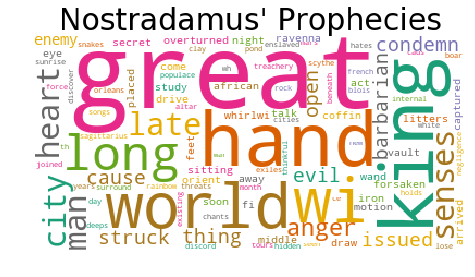

In [16]:
stop_word_list = ['able', 'according', 'aix', 'la', 'dy', 'having', 'l', 'le',
                  'li', 'o', 's', "’", 'very', 'like', 'sens', 'did', "'",
                  "'a", "'i", "'k", "'l", "'o", "'s", ',', '[', ']']
stop_words = text.ENGLISH_STOP_WORDS.union(stop_word_list)
wc = WordCloud(background_color = 'white', max_words = 100, stopwords=stop_words, colormap = 'Dark2_r')
wc.generate(str(df['prophecy']))
plt.figure(figsize=(15,4))
plt.imshow(wc)
plt.axis("off")
plt.savefig('NostradamusProphecies'+'.png', bbox_inches = 'tight')
plt.title("Nostradamus' Prophecies", fontsize = 30)
plt.show()
plt.close()

In [17]:
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
tokenized_list = []
for i in range(0, len(df['prophecy']) - 1):
    for original_word in df['prophecy'][i].split():
        word = re.sub(r"[^A-Za-z0-9\-]", " ", original_word).lower().split()
        lemma_word = [lemma.lemmatize(t, pos = 'v') for t in word_tokenize(word[0])][0]
        stem_word = [stemmer.stem(str(lemma_word))][0]
        tokenized_list.append(stem_word + ", " + original_word)
        
tokenized_df = pd.DataFrame(tokenized_list)

In [18]:
tokenized_df.head()

,0
0,"sit, sitting"
1,"alon, alone"
2,"at, at"
3,"night, night"
4,"in, in"


In [19]:
tokenized_df[1] = [item[1] for item in tokenized_df[0].str.split(', ')]
tokenized_df[0] = [item[0] for item in tokenized_df[0].str.split(', ')]
tokenized_df.rename({0: 'stem', 1: 'original_word'}, axis = 1, inplace = True)
tokenized_df['original_word_copy'] = deepcopy(tokenized_df['original_word'])

In [20]:
aggregations = {
    'original_word_copy': 'count'
    }

tokenized_df_group = tokenized_df.groupby(['stem', 'original_word']).agg(aggregations).reset_index()

In [21]:
duplicate_list = ['stem']

tokenized_df_group.drop_duplicates(subset = duplicate_list, keep = 'first', inplace = True)

In [22]:
tokenized_df_group = tokenized_df_group.reset_index()
tokenized_df_group.drop('index', axis = 1, inplace = True)

In [23]:
tokenized_df_group.to_pickle('tokenized_df_group.pkl')

In [24]:
tokenized_df_group = pd.read_pickle('tokenized_df_group.pkl')

#### Unigram LDA Modeling with Gensim (Count Vectorizer)

In [25]:
cv1_df = dtm_unigram(CountVectorizer, tokenized_df_group, df['prophecy'], 4)[1]

In [26]:
len(cv1_df.columns)

778

In [27]:
word_dic = {}
for i, word in enumerate(cv1_df.columns):
    word_dic[word] = i

In [28]:
len(word_dic)

777

In [29]:
counts = sparse.csr_matrix(cv1_df.values.T)
print(counts.shape)
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in word_dic.items())
print(len(id2word))

In [34]:
lda = models.LdaModel(corpus = corpus, num_topics = 4, id2word = id2word, passes = 50)

In [35]:
lda.print_topics()

[(0,
  '0.040*"great" + 0.019*"come" + 0.014*"lead" + 0.013*"man" + 0.012*"barbarian" + 0.012*"law" + 0.011*"king" + 0.010*"bleed" + 0.009*"open" + 0.009*"land"'),
 (1,
  '0.055*"great" + 0.025*"die" + 0.014*"king" + 0.013*"time" + 0.013*"very" + 0.012*"bleed" + 0.012*"long" + 0.011*"far" + 0.011*"near" + 0.011*"come"'),
 (2,
  '0.024*"great" + 0.019*"king" + 0.017*"die" + 0.017*"people" + 0.016*"come" + 0.014*"new" + 0.013*"near" + 0.013*"red" + 0.012*"cities" + 0.011*"chief"'),
 (3,
  '0.035*"great" + 0.019*"place" + 0.016*"war" + 0.015*"land" + 0.015*"sea" + 0.012*"long" + 0.011*"come" + 0.010*"france" + 0.010*"near" + 0.010*"carried"')]

In [89]:
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:5]

[[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)],
 [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)],
 [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)],
 [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)],
 [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]]

In [39]:
lda = models.LdaModel(corpus = corpus, num_topics = 5, id2word = id2word, passes = 50)

In [40]:
print('LDA w/ CountVectorizer Unigrams, Max_Df = 4')
lda.print_topics()

LDA w/ CountVectorizer Unigrams, Max_Df = 4


[(0,
  '0.043*"great" + 0.017*"place" + 0.014*"near" + 0.014*"bleed" + 0.013*"tremble" + 0.011*"king" + 0.010*"enemies" + 0.010*"new" + 0.010*"cities" + 0.010*"war"'),
 (1,
  '0.039*"die" + 0.022*"come" + 0.017*"great" + 0.015*"bleed" + 0.013*"law" + 0.013*"king" + 0.013*"time" + 0.012*"long" + 0.012*"realm" + 0.009*"empire"'),
 (2,
  '0.051*"great" + 0.028*"people" + 0.018*"sea" + 0.014*"die" + 0.013*"because" + 0.012*"come" + 0.012*"armies" + 0.010*"land" + 0.010*"capture" + 0.009*"near"'),
 (3,
  '0.032*"great" + 0.022*"king" + 0.015*"new" + 0.014*"prince" + 0.011*"very" + 0.011*"ladies" + 0.011*"die" + 0.010*"hand" + 0.010*"realm" + 0.009*"near"'),
 (4,
  '0.047*"great" + 0.018*"land" + 0.018*"come" + 0.014*"made" + 0.013*"very" + 0.012*"sea" + 0.011*"die" + 0.011*"near" + 0.011*"king" + 0.011*"ski"')]

In [42]:
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:5]

#### Bigram LDA Modeling with Gensim (Count Vectorizer)

In [44]:
cv2_df = dtm_bigram(TfidfVectorizer, tokenized_df_group, df['prophecy'], 3)[1]

In [45]:
len(cv2_df.columns)

135

In [46]:
cv2_df.head()

,act deceit,adriatic sea,apennine mountain,beard star,because die,before great,betray great,bleed die,bleed shed,bodies soul,born near,bridge broken,british isle,capture hostage,cause great,change law,child born,cities great,come late,come very,commit great,conflict given,conflict great,conflict near,conflict very,cut piece,die because,die capture,die great,divine word,earth tremble,famine plague,far away,father son,field town,fleur lis,foreign nation,ghent brussels,gold silver,great armies,great chief,great chyren,great cities,great discord,great empire,great evil,great fled,great force,great king,great ladies,great led,great lose,great man,great murder,great neptune,great number,great people,great plague,great pontiff,great prince,great river,great roman,great scandal,great terror,great troop,great war,high low,holy law,holy temple,human bleed,join together,king join,lake geneva,land sea,lead great,led capture,little great,long rain,long rest,long time,made war,marvel deed,military hand,monster born,moon complete,naval battle,near great,near river,new cities,new king,new land,new league,old man,pass pyrenees,pass sea,people die,place discover,place land,plague famine,plague war,po great,pyrenees mountain,realm great,red black,sea land,seen ski,seven day,seven month,seven year,shaven head,short afterwards,short before,short time,siege laid,son great,speak great,stained bleed,struck ski,swim bleed,time approach,time need,trojan bleed,very far,very great,very high,very horrible,very long,very near,very strong,wall fall,war open,wish consent,year seven,young man,young old
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [47]:
word_dic = {}
for i, word in enumerate(cv2_df.columns):
    word_dic[word] = i

In [48]:
len(word_dic)

135

In [49]:
counts = sparse.csr_matrix(cv2_df.values.T)
print(counts.shape)
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in word_dic.items())
print(len(id2word))

In [54]:
lda = models.LdaModel(corpus = corpus, num_topics = 5, id2word = id2word, passes = 50)

In [55]:
print('LDA w/ CountVectorizer Bigrams, Max_Df = 3')
lda.print_topics()

LDA w/ CountVectorizer Bigrams, Max_Df = 3


[(0,
  '0.117*"land sea" + 0.089*"very great" + 0.063*"great armies" + 0.037*"great empire" + 0.033*"come late" + 0.029*"new king" + 0.028*"earth tremble" + 0.025*"pyrenees mountain" + 0.023*"adriatic sea" + 0.023*"conflict very"'),
 (1,
  '0.038*"shaven head" + 0.037*"new cities" + 0.036*"stained bleed" + 0.031*"very far" + 0.030*"join together" + 0.029*"foreign nation" + 0.029*"long rain" + 0.029*"sea land" + 0.027*"wall fall" + 0.026*"red black"'),
 (2,
  '0.048*"great number" + 0.047*"seven year" + 0.041*"seven day" + 0.039*"short time" + 0.038*"very near" + 0.036*"cut piece" + 0.033*"die capture" + 0.029*"wish consent" + 0.029*"place discover" + 0.029*"monster born"'),
 (3,
  '0.087*"great cities" + 0.065*"great king" + 0.047*"conflict near" + 0.039*"famine plague" + 0.038*"betray great" + 0.035*"long rest" + 0.034*"very high" + 0.032*"made war" + 0.032*"son great" + 0.032*"military hand"'),
 (4,
  '0.139*"long time" + 0.046*"seven month" + 0.037*"british isle" + 0.033*"swim bleed

In [56]:
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:5]

#### LSA Modeling with Truncated SVD

In [59]:
X_1 = dtm_unigram(TfidfVectorizer, tokenized_df_group, df['prophecy'], 4)[0]
tfidf1_df = dtm_unigram(TfidfVectorizer, tokenized_df_group, df['prophecy'], 4)[1]

In [60]:
len(tfidf1_df.columns)

778

In [61]:
X_2 = dtm_bigram(TfidfVectorizer, tokenized_df_group, df['prophecy'], 3)[0]
tfidf2_df = dtm_bigram(TfidfVectorizer, tokenized_df_group, df['prophecy'], 3)[1]

In [62]:
len(tfidf2_df.columns)

135

In [63]:
tfidf2_df.head()

,act deceit,adriatic sea,apennine mountain,beard star,because die,before great,betray great,bleed die,bleed shed,bodies soul,born near,bridge broken,british isle,capture hostage,cause great,change law,child born,cities great,come late,come very,commit great,conflict given,conflict great,conflict near,conflict very,cut piece,die because,die capture,die great,divine word,earth tremble,famine plague,far away,father son,field town,fleur lis,foreign nation,ghent brussels,gold silver,great armies,great chief,great chyren,great cities,great discord,great empire,great evil,great fled,great force,great king,great ladies,great led,great lose,great man,great murder,great neptune,great number,great people,great plague,great pontiff,great prince,great river,great roman,great scandal,great terror,great troop,great war,high low,holy law,holy temple,human bleed,join together,king join,lake geneva,land sea,lead great,led capture,little great,long rain,long rest,long time,made war,marvel deed,military hand,monster born,moon complete,naval battle,near great,near river,new cities,new king,new land,new league,old man,pass pyrenees,pass sea,people die,place discover,place land,plague famine,plague war,po great,pyrenees mountain,realm great,red black,sea land,seen ski,seven day,seven month,seven year,shaven head,short afterwards,short before,short time,siege laid,son great,speak great,stained bleed,struck ski,swim bleed,time approach,time need,trojan bleed,very far,very great,very high,very horrible,very long,very near,very strong,wall fall,war open,wish consent,year seven,young man,young old
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Model Fitting

In [64]:
lsa = TruncatedSVD(4, algorithm = 'arpack')
print(lsa)

TruncatedSVD(algorithm='arpack', n_components=4, n_iter=5, random_state=None,
       tol=0.0)


In [65]:
X_lsa = lsa.fit_transform(X_1)
X_lsa = Normalizer(copy = False).fit_transform(X_lsa)
print(lsa.explained_variance_ratio_)

In [67]:
# lsa.components_

In [68]:
print('LSA w/ TFIDF Unigrams, Max_Df = 4')
display_topics(lsa, list(tfidf1_df.columns), 15)

LSA w/ TFIDF Unigrams, Max_Df = 4

Topic  0
great, die, come, king, land, near, very, bleed, sea, people, long, time, cities, place, new

Topic  1
die, king, time, bleed, long, realm, year, capture, seven, life, conspirator, law, son, hand, wounded

Topic  2
land, die, sea, bleed, fleet, near, water, far, sudden, tremble, war, enemies, mountain, barbarian, because

Topic  3
come, sea, very, soon, high, land, prince, made, late, open, exterminate, chief, temple, murder, prompt


In [69]:
lsa = TruncatedSVD(5, algorithm = 'arpack')
print(lsa)

TruncatedSVD(algorithm='arpack', n_components=5, n_iter=5, random_state=None,
       tol=0.0)


In [70]:
X_lsa = lsa.fit_transform(X_1)
X_lsa = Normalizer(copy = False).fit_transform(X_lsa)
print(lsa.explained_variance_ratio_)

In [72]:
# lsa.components_

In [73]:
print('LSA w/ TFIDF Unigrams, Max_Df = 4')
display_topics(lsa, list(tfidf1_df.columns), 15)

LSA w/ TFIDF Unigrams, Max_Df = 4

Topic  0
great, die, come, king, land, near, very, bleed, sea, people, long, time, cities, place, new

Topic  1
die, king, time, bleed, long, realm, year, capture, seven, life, conspirator, law, son, hand, wounded

Topic  2
land, die, sea, bleed, fleet, near, water, far, sudden, tremble, war, enemies, mountain, barbarian, because

Topic  3
come, sea, very, soon, high, land, prince, made, late, open, exterminate, chief, temple, murder, prompt

Topic  4
time, place, change, long, land, made, war, year, sea, new, ski, sun, held, before, mars


In [74]:
lsa = TruncatedSVD(5, algorithm = 'arpack')
print(lsa)

TruncatedSVD(algorithm='arpack', n_components=5, n_iter=5, random_state=None,
       tol=0.0)


In [75]:
X_lsa = lsa.fit_transform(X_2)
X_lsa = Normalizer(copy = False).fit_transform(X_lsa)
print(lsa.explained_variance_ratio_)

array([0.03502794, 0.03402181, 0.0281422 , 0.01983514, 0.01829241])

In [77]:
# lsa.components_

In [78]:
print('LSA w/ TFIDF Bigrams, Max_Df = 3')
display_topics(lsa, list(tfidf2_df.columns), 10)

LSA w/ TFIDF Bigrams, Max_Df = 3

Topic  0
land sea, long time, very great, great troop, fleur lis, great armies, sea land, act deceit, high low, siege laid

Topic  1
long time, swim bleed, bleed shed, bleed die, die great, seen ski, young old, very long, new cities, new king

Topic  2
very great, great armies, famine plague, great terror, very long, very far, long rain, great plague, seven year, great king

Topic  3
great armies, new cities, near river, lead great, young man, capture hostage, great prince, great king, great roman, cities great

Topic  4
great cities, change law, gold silver, people die, great led, time approach, holy law, great people, seven month, little great


#### NMF

Unigrams

In [79]:
nmf_model = NMF(5)
X_1_nmf = nmf_model.fit_transform(X_1)
X_1_nmf = Normalizer(copy = False).fit_transform(X_1_nmf)

In [80]:
X_1_nmf.shape

(942, 5)

In [81]:
X_1_nmf.round(2)

array([[0.  , 0.  , 0.18, 0.92, 0.35],
       [0.  , 0.29, 0.83, 0.26, 0.41],
       [0.01, 0.  , 0.  , 0.  , 1.  ],
       ...,
       [0.63, 0.  , 0.77, 0.1 , 0.  ],
       [0.87, 0.18, 0.  , 0.  , 0.47],
       [0.18, 0.  , 0.98, 0.  , 0.  ]])

In [82]:
nmf_model.components_.shape

(5, 778)

In [83]:
np.dot(X_1_nmf, nmf_model.components_).round(2)

array([[0.03, 0.02, 0.02, ..., 0.02, 0.11, 0.04],
       [0.01, 0.02, 0.02, ..., 0.02, 0.13, 0.07],
       [0.  , 0.04, 0.03, ..., 0.04, 0.31, 0.07],
       ...,
       [0.03, 0.01, 0.  , ..., 0.  , 0.  , 0.07],
       [0.04, 0.02, 0.01, ..., 0.02, 0.15, 0.1 ],
       [0.01, 0.01, 0.  , ..., 0.  , 0.  , 0.05]])

Bigrams

In [84]:
nmf_model = NMF(5)
X_2_nmf = nmf_model.fit_transform(X_2)
X_2_nmf = Normalizer(copy=False).fit_transform(X_2_nmf)

In [85]:
X_2_nmf.shape

(942, 5)

In [86]:
X_2_nmf.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.91, 0.  , 0.41, 0.  , 0.  ]])

In [87]:
nmf_model.components_.shape

(5, 135)

In [88]:
np.dot(X_2_nmf, nmf_model.components_).round(2)

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.14, 0.  ],
       [0.09, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])